In [1]:
from pathlib import Path
import os
import sys
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import statistics
%matplotlib inline

from keras import layers
from keras import models
from keras import optimizers
from keras.utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# create directories for where data sources are stored. Original source of data can be downloaded here:
# https://www.kaggle.com/sovitrath/sports-image-dataset
parent_dir = Path(os.getcwd()).absolute()
data_dir = os.path.join(parent_dir,'sports_images')
data_path = os.path.join(data_dir,'train/train')
image_labels_path = os.path.join(data_dir,'train_labels.csv')

In [3]:
# create dict of labels and their corresponding numeric representation
labels = {'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6,
          'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 
          'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18,
          'weight_lifting': 19, 'wrestling': 20, 'wwe': 21}

# create a dataframe of the image labels
image_labels = pd.read_csv(image_labels_path)

# map the labels to their corresponding numeric representation
image_labels['label_number'] = image_labels['sports'].map(labels)

# list of just the label numbers
image_labels_numerical = image_labels['label_number']

# create a list of the file names
file = []
for image in image_labels['image']:
    name = image.split('/')[2]
    file.append(name)
    
# create a new column with just the file names
image_labels['file'] = file
    
# create a dict of the files and their corresponding numeric label
file_dict = pd.Series(image_labels.label_number.values,index=image_labels.file).to_dict()

image_labels.head()

,image,sports,label_number,file
0,./train/0.jpg,baseball,1,0.jpg
1,./train/1.jpg,formula1,8,1.jpg
2,./train/2.jpg,fencing,6,2.jpg
3,./train/3.jpg,motogp,13,3.jpg
4,./train/4.jpg,ice_hockey,11,4.jpg


In [4]:
# create a function that loads each image and transforms it into an array fit for modeling
def create_dataset(img_folder, img_width, img_height):
    img_data_array=[]
    
    for file in os.listdir(img_folder):
        if not file.startswith('.'):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(img_height, img_width),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            img_data_array.append([file,image])
        else:
            continue
    
    return img_data_array

In [5]:
# run the image transformation function on the images
image_attributes = create_dataset(data_path, 64, 64)

# create a dataframe of the file name and transformed images
image_df = pd.DataFrame(image_attributes, columns = ['file','image'])
# add a label column of the numeric label for each image
image_df['label'] = image_df['file'].map(file_dict)
image_df.head()

,file,image,label
0,9733.jpg,"[[[43, 26, 15], [43, 26, 15], [84, 46, 16], [1...",1
1,63.jpg,"[[[157, 166, 175], [153, 162, 171], [143, 153,...",0
2,6400.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6
3,823.jpg,"[[[19, 14, 5], [15, 13, 9], [16, 18, 18], [21,...",5
4,4217.jpg,"[[[64, 145, 126], [66, 147, 127], [70, 149, 12...",13


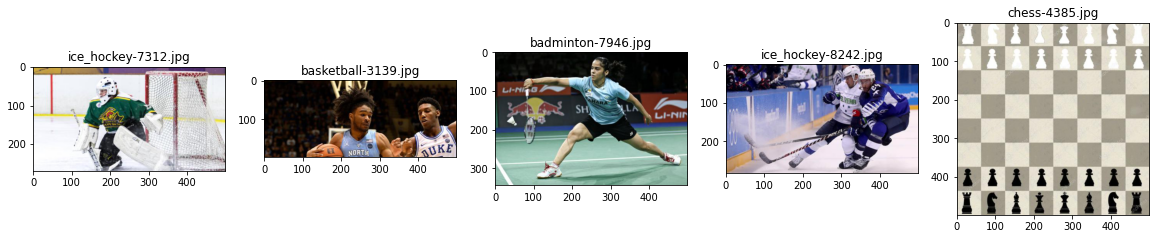

In [6]:
# Printing random five images
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(data_path))
    image_path = os.path.join(data_path, file)
    image_details = image_df[image_df['file'] == file]
    image_label = image_details.iloc[0]['label']
    label_name = []
    for key, value in labels.items():
        if value == image_label:
            label_name.append(key)
    image_name = label_name[0]
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(str(image_name)+"-"+str(file))
    plt.imshow(img)

In [7]:
# create a function that transforms the features fit for a neural network

def neural_network_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64 * 64 * 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64 * 64 * 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)
    # create a validation set
    image_val = train_images[:1000]
    partial_image_train = train_images[1000:]
    
    label_val = train_labels[:1000]
    partial_label_train = train_labels[1000:]
    
    return image_val, partial_image_train, label_val, partial_label_train


# create a function that transforms the features fit for a testing a neural network

def neural_network_eval_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64 * 64 * 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64 * 64 * 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)

    
    return train_images, train_labels, test_images, test_labels

In [8]:
# create a function to run a simple neural network
def simple_neural_network(learning_rate, epochs):
    network = models.Sequential()
    network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
    network.add(layers.Dense(22, activation = 'softmax'))
    network.compile(optimizer=optimizers.Adam(lr=learning_rate), loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])
    history = network.fit(partial_image_train, partial_label_train, epochs=epochs, batch_size=128,
              validation_data = (image_val, label_val))
    accuracy = history.history['accuracy']
    accuracy = statistics.mean(accuracy) 
    results_list.append([learning_rate,accuracy])

In [9]:
# create a list of all of the learning rates to test with
learning_rate = [10e-3, 10e-4 , 10e-5, 10e-6, 10e-7, 10e-8]
results_list = []

# prepare the data for modeling
image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

# run the data through the model for all 6 learning rates to determine the best learning rate for future modeling
for lr in learning_rate:
    simple_neural_network(lr, 5)

Train on 7280 samples, validate on 1000 samples
Epoch 1/5
7280/7280 [==============================] - ETA: 0s - loss: 15.1352 - accuracy: 0.0471WARNING:tensorflow:From /Users/kenny/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
7280/7280 [==============================] - 7s 911us/sample - loss: 15.1352 - accuracy: 0.0471 - val_loss: 15.5378 - val_accuracy: 0.0360
Epoch 2/5
7280/7280 [==============================] - 5s 729us/sample - loss: 15.3506 - accuracy: 0.0473 - val_loss: 15.5378 - val_accuracy: 0.0360
Epoch 3/5
7280/7280 [==============================] - 6s 830us/sample - loss: 15.3947 - accuracy: 0.0446 - val_loss: 15.4250 - val_accuracy: 0.0430
Epoch 4/5
7280/7280 [===========================

In [10]:
# reveiw the top 5 optimizer learning rates
best_optimizers = pd.DataFrame(results_list, columns =
                               ['Learning_Rate','Accuracy']).sort_values(by=['Accuracy'],
                                                         ascending=False).reset_index(drop = True)
best_optimizers.head()

,Learning_Rate,Accuracy
0,1.000000e-04,0.265742
1,1.000000e-03,0.207857
2,1.000000e-05,0.207830
3,1.000000e-06,0.107637
4,1.000000e-07,0.059451


I will proceed with using lr=0.0001 for the rest of my models that use Adam for the optimizer

In [11]:
# create a function that plots the models performance for analysis
def plot_model(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
# create a list to store the results of the future models
modeling_results = []

Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 8s 1ms/sample - loss: 2.8908 - accuracy: 0.1497 - val_loss: 2.7477 - val_accuracy: 0.1890
Epoch 2/30
7280/7280 [==============================] - 5s 636us/sample - loss: 2.5964 - accuracy: 0.2440 - val_loss: 2.6751 - val_accuracy: 0.2210
Epoch 3/30
7280/7280 [==============================] - 6s 786us/sample - loss: 2.4792 - accuracy: 0.2826 - val_loss: 2.5942 - val_accuracy: 0.2370
Epoch 4/30
7280/7280 [==============================] - 5s 753us/sample - loss: 2.3894 - accuracy: 0.3110 - val_loss: 2.5379 - val_accuracy: 0.2690
Epoch 5/30
7280/7280 [==============================] - 6s 796us/sample - loss: 2.3184 - accuracy: 0.3397 - val_loss: 2.5621 - val_accuracy: 0.2560
Epoch 6/30
7280/7280 [==============================] - 6s 781us/sample - loss: 2.2565 - accuracy: 0.3536 - val_loss: 2.5170 - val_accuracy: 0.2610
Epoch 7/30
7280/7280 [==============================] - 5s 625us/s

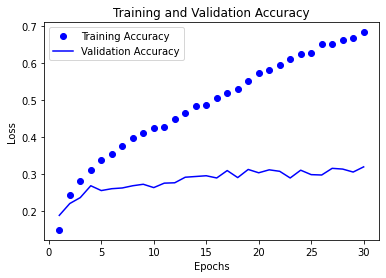

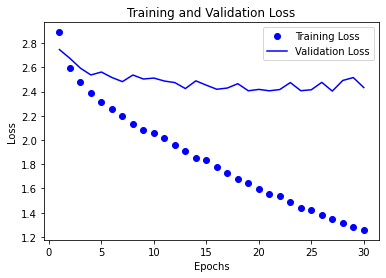

In [13]:
# Simple Neural Network

# run a model of a simple neural network with no optimization strategies

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 27 epochs with the best accuracy and lowest loss on the training data. I am going to run 27 epochs in test

In [14]:
# Evaluate the Simple Neural Network

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=27, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 32%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 8s 1ms/sample - loss: 3.8094 - accuracy: 0.1659 - val_loss: 3.7151 - val_accuracy: 0.1890
Epoch 2/30
7280/7280 [==============================] - 7s 1ms/sample - loss: 3.4863 - accuracy: 0.2404 - val_loss: 3.6093 - val_accuracy: 0.1940
Epoch 3/30
7280/7280 [==============================] - 6s 884us/sample - loss: 3.3043 - accuracy: 0.2902 - val_loss: 3.4480 - val_accuracy: 0.2240
Epoch 4/30
7280/7280 [==============================] - 6s 848us/sample - loss: 3.1736 - accuracy: 0.3184 - val_loss: 3.3620 - val_accuracy: 0.2500
Epoch 5/30
7280/7280 [==============================] - 8s 1ms/sample - loss: 3.0632 - accuracy: 0.3374 - val_loss: 3.2596 - val_accuracy: 0.2660
Epoch 6/30
7280/7280 [==============================] - 7s 932us/sample - loss: 2.9602 - accuracy: 0.3665 - val_loss: 3.2358 - val_accuracy: 0.2630
Epoch 7/30
7280/7280 [==============================] - 6s 852us/sampl

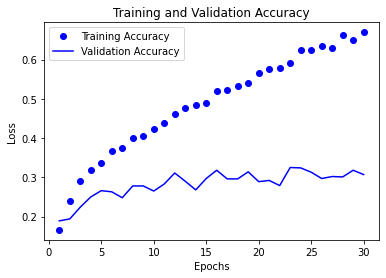

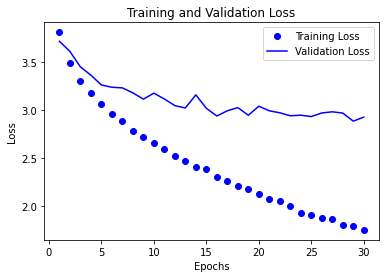

In [15]:
# Simple Neural Network with L2 Regularization Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 29 epochs with the best accuracy and lowest loss on the training data. I am going to run 29 epochs in test

In [16]:
# Evaluate the Simple Neural Network with L2 Regularization Penalty

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=29, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN L2 Reg','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 30%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 6s 848us/sample - loss: 62.5049 - accuracy: 0.1330 - val_loss: 53.1887 - val_accuracy: 0.1810
Epoch 2/30
7280/7280 [==============================] - 6s 885us/sample - loss: 45.1725 - accuracy: 0.2262 - val_loss: 37.5768 - val_accuracy: 0.2100
Epoch 3/30
7280/7280 [==============================] - 6s 849us/sample - loss: 31.3533 - accuracy: 0.2596 - val_loss: 25.7482 - val_accuracy: 0.2420
Epoch 4/30
7280/7280 [==============================] - 6s 761us/sample - loss: 21.4208 - accuracy: 0.2871 - val_loss: 17.8353 - val_accuracy: 0.2410
Epoch 5/30
7280/7280 [==============================] - 6s 882us/sample - loss: 15.1608 - accuracy: 0.3029 - val_loss: 13.1062 - val_accuracy: 0.2210
Epoch 6/30
7280/7280 [==============================] - 6s 868us/sample - loss: 11.3765 - accuracy: 0.3036 - val_loss: 10.1388 - val_accuracy: 0.2320
Epoch 7/30
7280/7280 [==============================

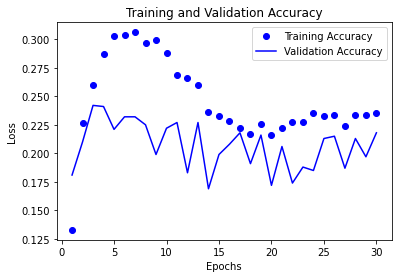

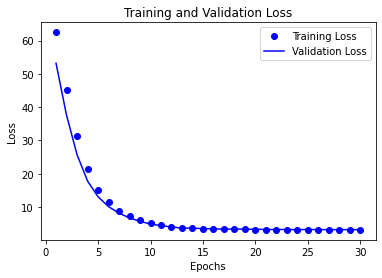

In [17]:
# Simple Neural Network with L1 Regularization Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 13 epochs with the best accuracy and lowest loss on the training data. I am going to run 13 epochs in test

In [18]:
# Evaluate the Simple Neural Network with L1 Regularization Penalty

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), 
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=13, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN L1 Reg','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 20%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 11s 1ms/sample - loss: 63.5014 - accuracy: 0.1437 - val_loss: 54.2147 - val_accuracy: 0.1880
Epoch 2/30
7280/7280 [==============================] - 8s 1ms/sample - loss: 46.1284 - accuracy: 0.2360 - val_loss: 38.5017 - val_accuracy: 0.1940
Epoch 3/30
7280/7280 [==============================] - 10s 1ms/sample - loss: 32.2033 - accuracy: 0.2545 - val_loss: 26.5855 - val_accuracy: 0.2040
Epoch 4/30
7280/7280 [==============================] - 7s 921us/sample - loss: 22.0896 - accuracy: 0.2816 - val_loss: 18.3754 - val_accuracy: 0.2470
Epoch 5/30
7280/7280 [==============================] - 7s 958us/sample - loss: 15.5711 - accuracy: 0.2948 - val_loss: 13.4050 - val_accuracy: 0.2080
Epoch 6/30
7280/7280 [==============================] - 7s 899us/sample - loss: 11.5058 - accuracy: 0.3048 - val_loss: 10.1822 - val_accuracy: 0.2370
Epoch 7/30
7280/7280 [==============================] - 

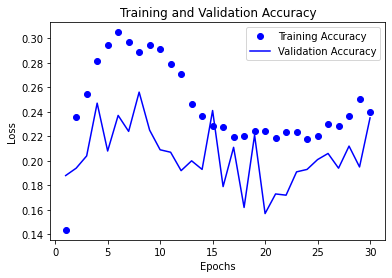

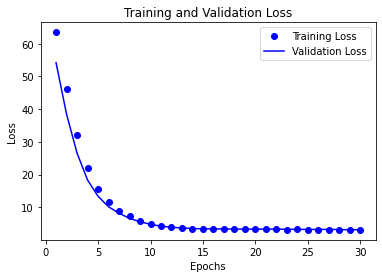

In [19]:
# Simple Neural Network with Simultaneous L1 and L2 Regularization Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 15 ephocs with the best accuracy and lowest loss on the training data. I am going to run 15 epochs in test

In [20]:
# Evaluate the Simultaneous L1 and L2 Regularization Penalty

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
                         activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=15, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN L1/L2 Reg','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 23%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 8s 1ms/sample - loss: 2.9983 - accuracy: 0.1190 - val_loss: 2.8617 - val_accuracy: 0.1860
Epoch 2/30
7280/7280 [==============================] - 7s 916us/sample - loss: 2.8038 - accuracy: 0.1720 - val_loss: 2.7642 - val_accuracy: 0.1890
Epoch 3/30
7280/7280 [==============================] - 6s 868us/sample - loss: 2.7369 - accuracy: 0.1951 - val_loss: 2.6981 - val_accuracy: 0.2200
Epoch 4/30
7280/7280 [==============================] - 6s 866us/sample - loss: 2.6734 - accuracy: 0.2181 - val_loss: 2.6715 - val_accuracy: 0.2330
Epoch 5/30
7280/7280 [==============================] - 6s 869us/sample - loss: 2.6282 - accuracy: 0.2202 - val_loss: 2.5985 - val_accuracy: 0.2510
Epoch 6/30
7280/7280 [==============================] - 4s 593us/sample - loss: 2.5776 - accuracy: 0.2412 - val_loss: 2.5768 - val_accuracy: 0.2370
Epoch 7/30
7280/7280 [==============================] - 7s 943us/s

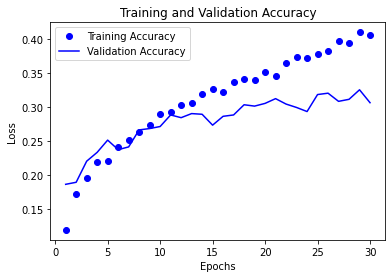

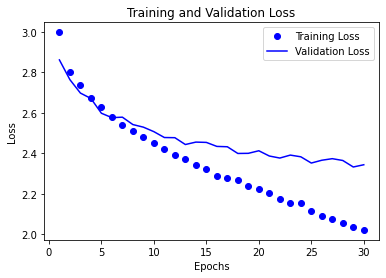

In [21]:
# Simple Neural Network with Dropout Penalty

image_val, partial_image_train, label_val, partial_label_train = neural_network_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = network.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 26 ephocs with the best accuracy and lowest loss on the training data. I am going to run 26 epochs in test

In [22]:
# Evaluate the Simple Neural Network with Dropout Penalty

train_images, train_labels, test_images, test_labels = neural_network_eval_features(image_df)

network = models.Sequential()
network.add(layers.Dense(512, activation = 'relu', input_shape=(64 * 64 * 3,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(22, activation = 'softmax'))

network.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

network.fit(train_images, train_labels, epochs=26, batch_size=128, verbose = 0)

test_loss, test_acc = network.evaluate(test_images, test_labels)
modeling_results.append(['Simple NN Dropout','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 31%


In [23]:
# Review the results of all of the Simple Neural Network models and compare

pd.DataFrame(modeling_results, columns = ['Model_Type', 'Optimization',
                                          'Accuracy']).sort_values(by=['Accuracy'],
                                                                   ascending=False).reset_index(drop = True)

,Model_Type,Optimization,Accuracy
0,Simple NN,Adam,0.324638
1,Simple NN Dropout,Adam,0.314855
2,Simple NN L2 Reg,Adam,0.301812
3,Simple NN L1/L2 Reg,Adam,0.225725
4,Simple NN L1 Reg,Adam,0.198913


It looks like so far, the Neural Network model performed the best. Let's see what happens when we start modeling with Convolutional Neural Networks and if the performance increase.

In [24]:
# create a function that transforms the features fit for a Convolutional Neural Network

def cnn_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64, 64, 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64, 64, 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)
    # create a validation set
    image_val = train_images[:1000]
    partial_image_train = train_images[1000:]
    
    label_val = train_labels[:1000]
    partial_label_train = train_labels[1000:]
    
    return image_val, partial_image_train, label_val, partial_label_train


# create a function that transforms the features fit for a testing a Convolutional Neural Network

def cnn_eval_features(df):

    seventy_five = int(len(df)*0.75)
    # split the df 75%-25%
    train_df = df[:seventy_five]
    test_df = df[seventy_five:]
    # extract out just the image array data from the dataframe 
    train_images = []
    for array in train_df['image']:
        train_images.append(array)
    train_images = np.array(train_images)
    # reshape and format the images for modeling
    train_images = train_images.reshape((8280, 64, 64, 3))
    train_images = train_images.astype('float32') / 255
    # repeate for test images
    test_images = []
    for array in test_df['image']:
        test_images.append(array)
    test_images = np.array(test_images)
    test_images = test_images.reshape((2760, 64, 64, 3))
    test_images = test_images.astype('float32') / 255
    # create a list of the train and test labels
    train_labels = np.array(train_df['label'])
    train_labels = to_categorical(train_labels)

    test_labels  = np.array(test_df['label'])
    test_labels = to_categorical(test_labels)

    
    return train_images, train_labels, test_images, test_labels

In [25]:
# create a function to run a CNN

cnn_results_list = []

def test_CNN(learning_rate, epochs):   
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(22, activation = 'softmax'))

    model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    history = model.fit(partial_image_train, partial_label_train, epochs=epochs, batch_size=128,
                        validation_data = (image_val, label_val))
    
    accuracy = history.history['accuracy']
    accuracy = statistics.mean(accuracy) 
    cnn_results_list.append([learning_rate,accuracy])

In [26]:
# create a list of all of the learning rates to test with
learning_rate = [10e-3, 10e-4 , 10e-5, 10e-6, 10e-7, 10e-8]

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

# run the data through the model for all 6 learning rates to determine the best learning rate for future modeling

for lr in learning_rate:
    test_CNN(lr, 5)

Train on 7280 samples, validate on 1000 samples
Epoch 1/5
7280/7280 [==============================] - 32s 4ms/sample - loss: 3.3120 - accuracy: 0.0618 - val_loss: 3.0889 - val_accuracy: 0.0550
Epoch 2/5
7280/7280 [==============================] - 31s 4ms/sample - loss: 3.0795 - accuracy: 0.0657 - val_loss: 3.0852 - val_accuracy: 0.0550
Epoch 3/5
7280/7280 [==============================] - 33s 4ms/sample - loss: 3.0788 - accuracy: 0.0657 - val_loss: 3.0893 - val_accuracy: 0.0550
Epoch 4/5
7280/7280 [==============================] - 33s 5ms/sample - loss: 3.0783 - accuracy: 0.0655 - val_loss: 3.0889 - val_accuracy: 0.0550
Epoch 5/5
7280/7280 [==============================] - 30s 4ms/sample - loss: 3.0778 - accuracy: 0.0657 - val_loss: 3.0878 - val_accuracy: 0.0550
Train on 7280 samples, validate on 1000 samples
Epoch 1/5
7280/7280 [==============================] - 31s 4ms/sample - loss: 2.8967 - accuracy: 0.1161 - val_loss: 2.7235 - val_accuracy: 0.1560
Epoch 2/5
7280/7280 [=======

In [30]:
best_optimizers = pd.DataFrame(cnn_results_list, columns =
                               ['Learning_Rate','Accuracy']).sort_values(by=['Accuracy'],
                                                                         ascending=False).reset_index(drop = True)
best_optimizers.head()

,Learning_Rate,Accuracy
0,1.000000e-02,0.068709
1,1.000000e-04,0.065110
2,1.000000e-05,0.051374
3,1.000000e-06,0.042857
4,1.000000e-07,0.041071


I will process with using lr=0.01 for the rest of my models that use Adam for the optimizer

Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 42s 6ms/sample - loss: 3.0626 - accuracy: 0.0824 - val_loss: 3.0216 - val_accuracy: 0.1300
Epoch 2/30
7280/7280 [==============================] - 41s 6ms/sample - loss: 2.8800 - accuracy: 0.1389 - val_loss: 2.7857 - val_accuracy: 0.1590
Epoch 3/30
7280/7280 [==============================] - 42s 6ms/sample - loss: 2.6998 - accuracy: 0.1930 - val_loss: 2.6769 - val_accuracy: 0.1890
Epoch 4/30
7280/7280 [==============================] - 43s 6ms/sample - loss: 2.5937 - accuracy: 0.2254 - val_loss: 2.6089 - val_accuracy: 0.2080
Epoch 5/30
7280/7280 [==============================] - 45s 6ms/sample - loss: 2.4809 - accuracy: 0.2610 - val_loss: 2.5020 - val_accuracy: 0.2390
Epoch 6/30
7280/7280 [==============================] - 38s 5ms/sample - loss: 2.3948 - accuracy: 0.2956 - val_loss: 2.4712 - val_accuracy: 0.2510
Epoch 7/30
7280/7280 [==============================] - 39s 5ms/sample

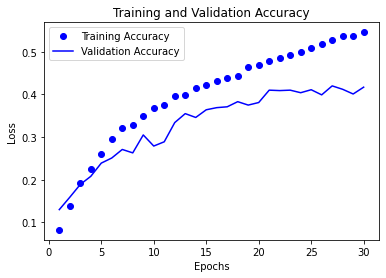

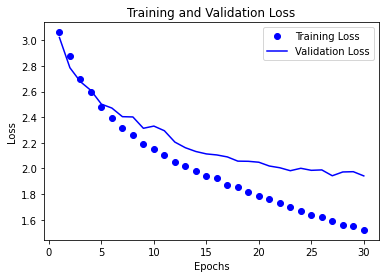

In [28]:
# Convolutional Neural Network

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accuracy and lowest loss, so I am going to run 30 epochs in test

In [29]:
# Evaluate the Convolutional Neural Network

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['Simple CNN','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 43%


Train on 7280 samples, validate on 1000 samples
Epoch 1/30
7280/7280 [==============================] - 39s 5ms/sample - loss: 3.0733 - accuracy: 0.0654 - val_loss: 3.0536 - val_accuracy: 0.0750
Epoch 2/30
7280/7280 [==============================] - 30s 4ms/sample - loss: 2.9470 - accuracy: 0.1136 - val_loss: 2.8551 - val_accuracy: 0.1200
Epoch 3/30
7280/7280 [==============================] - 30s 4ms/sample - loss: 2.7795 - accuracy: 0.1545 - val_loss: 2.7277 - val_accuracy: 0.1690
Epoch 4/30
7280/7280 [==============================] - 30s 4ms/sample - loss: 2.7020 - accuracy: 0.1694 - val_loss: 2.6466 - val_accuracy: 0.2010
Epoch 5/30
7280/7280 [==============================] - 30s 4ms/sample - loss: 2.6334 - accuracy: 0.2032 - val_loss: 2.5757 - val_accuracy: 0.2250
Epoch 6/30
7280/7280 [==============================] - 30s 4ms/sample - loss: 2.5670 - accuracy: 0.2280 - val_loss: 2.5051 - val_accuracy: 0.2550
Epoch 7/30
7280/7280 [==============================] - 30s 4ms/sample

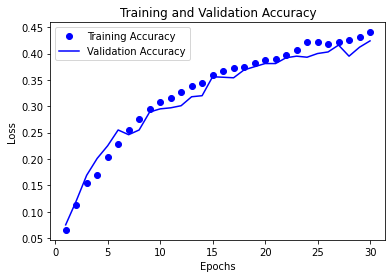

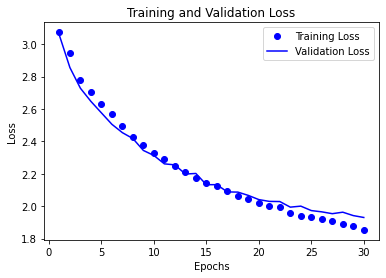

In [30]:
# Convolutional Neural Network with Dropout

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(partial_image_train, partial_label_train, epochs=30, batch_size=128,
                      validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accyracy and lowest loss, so I am going to run 30 epochs in test

In [31]:
# Evaluate the Convolutional Neural Network with Dropout - SGD

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['CNN w/Dropout','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 41%


Epoch 1/30
100/100 [==============================] - 17s 166ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0799 - accuracy: 0.0585 - val_loss: 3.0755 - val_accuracy: 0.0550
Epoch 2/30
100/100 [==============================] - 13s 135ms/step - batch: 49.5000 - size: 20.0000 - loss: 3.0606 - accuracy: 0.0720 - val_loss: 3.0337 - val_accuracy: 0.0820
Epoch 3/30
100/100 [==============================] - 13s 130ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.9468 - accuracy: 0.1155 - val_loss: 2.8771 - val_accuracy: 0.1180
Epoch 4/30
100/100 [==============================] - 14s 137ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.8313 - accuracy: 0.1355 - val_loss: 2.8439 - val_accuracy: 0.1240
Epoch 5/30
100/100 [==============================] - 13s 134ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.7732 - accuracy: 0.1445 - val_loss: 2.7649 - val_accuracy: 0.1630
Epoch 6/30
100/100 [==============================] - 14s 139ms/step - batch: 49.5000 - size: 20.0000 - loss: 

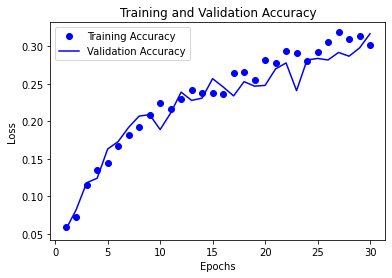

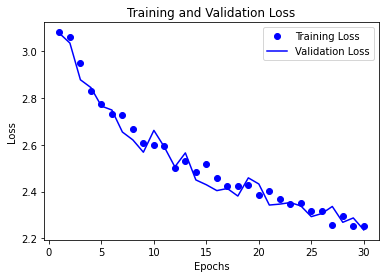

In [32]:
# Convolutional Neural Network with Data Augmentation and Dropout

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(64,64,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')#,rescale=1./255)

train_generator = train_datagen.flow(partial_image_train, partial_label_train, batch_size=20)

model.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accuracy and lowest loss, so I am going to run 30 epochs in test

In [33]:
# Evaluate Convolutional Neural Network with Data Augmentation and Dropout

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['CNN with Dropout and Data Augmention','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 33%


Epoch 1/30
100/100 [==============================] - 110s 1s/step - batch: 49.5000 - size: 20.0000 - loss: 2.6627 - accuracy: 0.2070 - val_loss: 2.2631 - val_accuracy: 0.3110
Epoch 2/30
100/100 [==============================] - 92s 924ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.2052 - accuracy: 0.3520 - val_loss: 1.9669 - val_accuracy: 0.4150
Epoch 3/30
100/100 [==============================] - 94s 938ms/step - batch: 49.5000 - size: 20.0000 - loss: 2.0000 - accuracy: 0.4025 - val_loss: 1.7812 - val_accuracy: 0.4630
Epoch 4/30
100/100 [==============================] - 110s 1s/step - batch: 49.5000 - size: 20.0000 - loss: 1.8476 - accuracy: 0.4320 - val_loss: 1.7347 - val_accuracy: 0.4860
Epoch 5/30
100/100 [==============================] - 94s 944ms/step - batch: 49.5000 - size: 20.0000 - loss: 1.7413 - accuracy: 0.4710 - val_loss: 1.6758 - val_accuracy: 0.5010
Epoch 6/30
100/100 [==============================] - 97s 965ms/step - batch: 49.5000 - size: 20.0000 - loss: 1.71

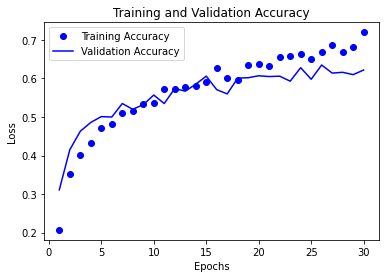

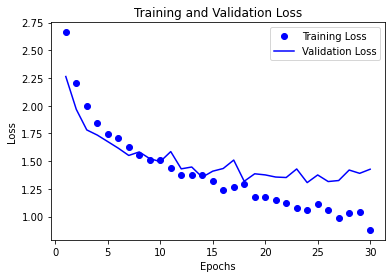

In [34]:
# Convolutional Neural Network with Pretrained Covnet (VGG16) Fine Tuning

image_val, partial_image_train, label_val, partial_label_train = cnn_features(image_df)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(partial_image_train, partial_label_train, batch_size=20)

model.compile(optimizer=optimizers.Adam(lr=0.00010), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, steps_per_epoch=100, epochs=30,
                    validation_data = (image_val, label_val))

plot_model(history)

The model peaks at about 30 with the best accuracy and lowest loss, so I am going to run 30 epochs in test

In [35]:
# Evaluate Convolutional Neural Network with Pretrained Covnet (VGG16) Fine Tuning

train_images, train_labels, test_images, test_labels = cnn_eval_features(image_df)

test_loss, test_acc = model.evaluate(test_images, test_labels)
modeling_results.append(['VGG16','Adam', test_acc])
print('test_acc:', "{:.0%}".format(test_acc))

test_acc: 62%


In [36]:
adam = pd.DataFrame(modeling_results, columns = ['Model_Type', 'Optimization',
                                                 'Accuracy']).sort_values(by=['Accuracy'],
                                                                          ascending=False).reset_index(drop = True)
adam.to_csv('adam.csv', index=False)

adam

,Model_Type,Optimization,Accuracy
0,VGG16,Adam,0.616667
1,Simple CNN,Adam,0.426449
2,CNN w/Dropout,Adam,0.413768
3,CNN with Dropout and Data Augmention,Adam,0.326087
4,Simple NN,Adam,0.324638
5,Simple NN Dropout,Adam,0.314855
6,Simple NN L2 Reg,Adam,0.301812
7,Simple NN L1/L2 Reg,Adam,0.225725
8,Simple NN L1 Reg,Adam,0.198913
